In [1]:
# Install all dependencies for sgementation-models-3D library.
# We will use this library to call 3D unet.
# Alternative, you can define your own Unet, if you have skills!
!pip install classification-models-3D
!pip install efficientnet-3D
!pip install segmentation-models-3D

# Use patchify to break large volumes into smaller for training 
#and also to put patches back together after prediction.
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.9/62.9 KB 2.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 3.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import h5py
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import logging

# funky librairies for segmentation
import segmentation_models_3D as sm
from patchify import patchify, unpatchify

print('All librairies sucessfully imported.')

Segmentation Models: using `tf.keras` framework.
All librairies sucessfully imported.


In [3]:
# import data
PATH_COLAB = '/content/drive/MyDrive/6_aneurysm_segmentation/challenge_dataset.zip'
PATH_DEVICE = './challenge_dataset/'

try:
    from google.colab import drive
    logging.info('Working on Colab.')
    
    # connect your drive to the session
    drive.mount('/content/drive')

    %cd /content/drive/MyDrive/6_aneurysm_segmentation/

    # unzip data into the colab session
    ! unzip $PATH_COLAB -d /content
    logging.info('Data unziped in your Drive.')

except:
    logging.info('Working on your device.')
    
    data_exists = os.path.exists(PATH_DEVICE)
    
    if data_exists:
        logging.info(f"Dataset found on device at : '{PATH_DEVICE}.'") 
    else:
        raise FileNotFoundError(f"Data folder not found at '{PATH_DEVICE}'")

Mounted at /content/drive
/content/drive/MyDrive/6_aneurysm_segmentation
Archive:  /content/drive/MyDrive/6_aneurysm_segmentation/challenge_dataset.zip
   creating: /content/challenge_dataset/
  inflating: /content/challenge_dataset/scan_1.h5  
  inflating: /content/challenge_dataset/scan_2.h5  
  inflating: /content/challenge_dataset/scan_3.h5  
  inflating: /content/challenge_dataset/scan_4.h5  
  inflating: /content/challenge_dataset/scan_5.h5  
  inflating: /content/challenge_dataset/scan_6.h5  
  inflating: /content/challenge_dataset/scan_7.h5  
  inflating: /content/challenge_dataset/scan_8.h5  
  inflating: /content/challenge_dataset/scan_9.h5  
  inflating: /content/challenge_dataset/scan_10.h5  
  inflating: /content/challenge_dataset/scan_11.h5  
  inflating: /content/challenge_dataset/scan_12.h5  
  inflating: /content/challenge_dataset/scan_13.h5  
  inflating: /content/challenge_dataset/scan_14.h5  
  inflating: /content/challenge_dataset/scan_15.h5  
  inflating: /content

# Get data

In [4]:
PATH_DATASET='./challenge_dataset/'
TEST_SIZE = 0.2 # % of test samples from the full dataset
VAL_SPLIT = 0.2 # % of training samples kept for the validation metrics
CROP = 64

In [5]:
# get file names
file_names = os.listdir(PATH_DATASET)
N = len(file_names)
print(f'{N} samples in dataset.')

# open all .h5 files, split inputs and target masks, store all in np.arrays
raw_data = []
labels = []
names = []

for file_name in tqdm(file_names):
    f = h5py.File(f'{PATH_DATASET}/{file_name}', 'r')

    X, Y = np.array(f['raw']), np.array(f['label'])

    X = X[:,CROP:2*CROP,CROP:2*CROP]
    Y = Y[:,CROP:2*CROP,CROP:2*CROP]

    raw_data.append(X)
    labels.append(Y)
    names.append(file_name)

    # X_patches = patchify(X, (64, 64, 64), step=64)  # Step=64 for 64 patches means no overlap
    # X_patches_resh = np.reshape(X_patches, (-1, X_patches.shape[3], X_patches.shape[4], X_patches.shape[5]))
    # Y_patches = patchify(Y, (64, 64, 64), step=64)  # Step=64 for 64 patches means no overlap
    # Y_patches_resh = np.reshape(Y_patches, (-1, Y_patches.shape[3], Y_patches.shape[4], Y_patches.shape[5]))
    # raw_data.append(X_patches_resh)
    # labels.append(Y_patches_resh)
    # names.append(file_name)

# convert to arrays for patchify
raw_data = np.array(raw_data)
labels = np.array(labels)

# raw_data = np.reshape(raw_data, (-1, raw_data.shape[2], raw_data.shape[3], raw_data.shape[4]))
# labels = np.reshape(labels, (-1, labels.shape[2], labels.shape[3], labels.shape[4]))

raw_data = np.stack((raw_data,) * 3, axis=-1)
labels = np.expand_dims(labels, axis=4)

# check shapes
print(raw_data.shape)
print(labels.shape)

103 samples in dataset.


100%|██████████| 103/103 [00:05<00:00, 18.15it/s]


(103, 64, 64, 64, 3)
(103, 64, 64, 64, 1)


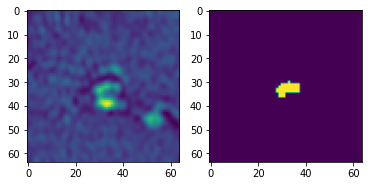

In [6]:
SCAN_ID = 45
DEPTH = 32

fig, ax = plt.subplots(1, 2)
ax[0].imshow(raw_data[SCAN_ID,:,:,DEPTH,0])
ax[1].imshow(labels[SCAN_ID,:,:,DEPTH,0]) # last 0 to get a 2D image
plt.show()

In [7]:
# split train and test data
X_train, X_test, y_train, y_test = train_test_split(raw_data, labels, test_size=TEST_SIZE)

# train_test_split returns lists, we want arrays for easier calls
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train, dtype='float32')
y_test = np.array(y_test, dtype='float32')

# check shapes
print(X_train.shape)
print(X_test.shape)

(82, 64, 64, 64, 3)
(21, 64, 64, 64, 3)


# Models

In [8]:
# Loss Function and coefficients to be used during training:
def custom_iou(smooth=1e-6):
    """
    Returns a IoU function, with a custom smoothing parameter.
    Such a double function is needed because loss function in Keras are expected
    to take only two parameters. Therefore, smooth couldn't be a parameter.
    """
    def IoULoss(targets, inputs):
        """
        Returns the intersection over union (IoU) of the two inputs masks.
        """
        targets = tf.cast(targets, tf.float32)
        # flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)

        intersection = K.sum(targets * inputs)
        total = K.sum(targets) + K.sum(inputs)
        union = total - intersection
        
        IoU = (intersection + smooth) / (union + smooth)
        return 1 - IoU

    return IoULoss

Backbones: ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'seresnet18', 'seresnet34', 'seresnet50', 'seresnet101', 'seresnet152', 'seresnext50', 'seresnext101', 'senet154', 'resnext50', 'resnext101', 'vgg16', 'vgg19', 'densenet121', 'densenet169', 'densenet201', 'inceptionresnetv2', 'inceptionv3', 'mobilenet', 'mobilenetv2', 'efficientnetb0', 'efficientnetb1', 'efficientnetb2', 'efficientnetb3', 'efficientnetb4', 'efficientnetb5', 'efficientnetb6', 'efficientnetb7']

So far, what worked best for our dataset (IOU_test = 43%) is:
```
BACKBONE = 'resnet50'
LOSS_TYPE = 'jaccard'
BATCH_SIZE = 8
LR = 1e-4
```

In [9]:
# MODEL PARAMETERS
encoder_weights = 'imagenet' # Try 'imagenet' or None (random initialization)
BACKBONE = 'resnet50'  # Try vgg16, efficientnetb7, inceptionv3, resnet50
activation = 'sigmoid' # final layer activation function, sigmoid for binary
patch_size = 64 # cube side length
n_classes = 1 # num channels output, here binary segmentation so 1
channels = 3 # num channels input, need 3 because backbones are trained on RGB
LOSS_TYPE = 'jaccard' # check dict 'losses' down below

# TRAINING PARAMETERS
LR = 1e-4 # starting learning rate
EPOCHS = 100
BATCH_SIZE = 8

MODEL_NAME = f'./3D_model_{BACKBONE}_{encoder_weights}weights_{EPOCHS}epochs_{LOSS_TYPE}'
print(MODEL_NAME)

/content/drive/MyDrive/6_aneurysm_segmentation/3D_model_resnet50_imagenetweights_100epochs_jaccard


In [10]:
# Define optimizer
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss() 
jaccard_loss = sm.losses.JaccardLoss()
focal_loss = sm.losses.BinaryFocalLoss()

losses = {'dice': dice_loss,
          'jaccard': custom_iou(),
          'focal_loss': focal_loss,
          'dice_focal': dice_loss + (1 * focal_loss), 
          'jaccard_focal': jaccard_loss + (1 * focal_loss), 
          }

total_loss = losses.get(LOSS_TYPE)
assert total_loss is not None, ('Loss not defined. Check your spelling of LOSS_TYPE or the dict losses.')

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [11]:
# add callbacks to monitor training 
weight_path = "{}_weights.best.hdf5".format(MODEL_NAME)

checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', 
                                   factor=0.5, 
                                   patience=5, 
                                   verbose=1, 
                                   mode='auto', 
                                   min_delta=0.0001, 
                                   cooldown=5, 
                                   min_lr=1e-5)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited

callbacks_list = [checkpoint, 
                  early, 
                  reduceLROnPlat]

In [12]:
# Preprocess input data - otherwise you end up with garbage resutls 
# and potentially model that does not converge.
preprocess_input = sm.get_preprocessing(BACKBONE)

X_train_prep = preprocess_input(X_train)
X_test_prep = preprocess_input(X_test)

In [31]:
# Define the model. Here we use Unet but we can also use other model architectures from the library.
model = sm.Unet(BACKBONE, classes=n_classes, 
                input_shape=(patch_size, patch_size, patch_size, channels), 
                encoder_weights=encoder_weights,
                activation=activation)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 64, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, 64, 64, 64,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding3d_18 (ZeroPadding  (None, 70, 70, 70,   0          ['bn_data[0][0]']                
 3D)                            3)                                                          

In [14]:
# Fit the model
history = model.fit(X_train_prep, 
                    y_train,
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS,
                    verbose=1,
                    validation_split=VAL_SPLIT,
                    callbacks=callbacks_list)

Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 0.9975 - iou_score: 0.0049 - f1-score: 0.0097
Epoch 1: val_loss improved from inf to 0.99761, saving model to /content/drive/MyDrive/6_aneurysm_segmentation/3D_model_resnet50_imagenetweights_100epochs_jaccard_weights.best.hdf5
9/9 [==============================] - 39s 1s/step - loss: 0.9975 - iou_score: 0.0049 - f1-score: 0.0097 - val_loss: 0.9976 - val_iou_score: 0.0095 - val_f1-score: 0.0188 - lr: 1.0000e-04
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 0.9961 - iou_score: 0.0063 - f1-score: 0.0125
Epoch 2: val_loss improved from 0.99761 to 0.99743, saving model to /content/drive/MyDrive/6_aneurysm_segmentation/3D_model_resnet50_imagenetweights_100epochs_jaccard_weights.best.hdf5
9/9 [==============================] - 8s 855ms/step - loss: 0.9961 - iou_score: 0.0063 - f1-score: 0.0125 - val_loss: 0.9974 - val_iou_score: 0.0036 - val_f1-score: 0.0072 - lr: 1.0000e-04
Epoch 3/100
9/9 [=============

In [ ]:
# Save model for future use
# model.save(f'{MODEL_NAME}.h5')
# print(f'Save at : {MODEL_NAME}.h5')

Save at : /content/drive/MyDrive/6_aneurysm_segmentation/3D_model_inceptionv3_imagenetweights_100epochs_jaccard+focal.h5


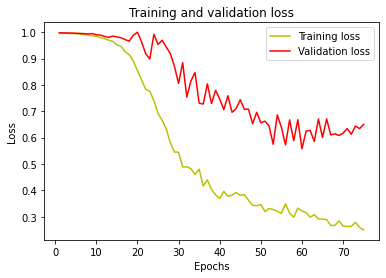

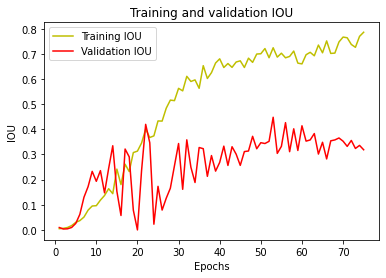

In [16]:
# plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [38]:
 # Load the pretrained model for testing and predictions. 
# you need a model instance before loading weights
print(f"Reload weights from : {MODEL_NAME}_weights.best.h5")
model.load_weights(f"{MODEL_NAME}_weights.best.hdf5")

Reload weights from : /content/drive/MyDrive/6_aneurysm_segmentation/3D_model_resnet50_imagenetweights_100epochs_jaccard_weights.best.h5


In [39]:
# Predict on the test data
y_pred = model.predict(X_test_prep)

sm.metrics.IOUScore(threshold=0.5)(y_pred, y_test)

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.4382146>

In [40]:
# Test some random images

# pick a random test scan and its ground truth mask
test_img_number = random.randint(0, len(X_test))
print(f'I choose test image n° {test_img_number} ...')

test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]

# process input image before prediction
test_img_input = np.expand_dims(test_img, 0)
test_img_input1 = preprocess_input(test_img_input)

# prediction
test_pred = model.predict(test_img_input1)
test_pred = test_pred.squeeze()

# thresholding + reshaping
print(test_pred.shape)

I choose test image n° 8 ...
1/1 [==============================] - 0s 34ms/step
(64, 64, 64)


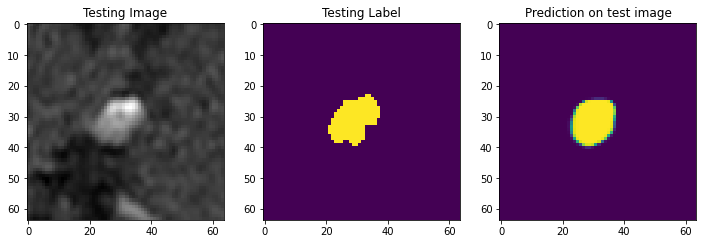

In [41]:
# Plot individual slices from test predictions for verification
slice = 32

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[slice,:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[slice,:,:,0])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred[slice,:,:])
plt.show()